In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
import pandas as pd
import torch
import numpy as np
import random
import re
import spacy
import shutil
import matplotlib.pyplot as plt
!pip install transformers
!pip install bertviz
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, BertTokenizer, AutoModel, BertModel
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, RandomSampler, SequentialSampler
import time
from scipy.stats import spearmanr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!wget -O Stsbenchmark.tar.gz http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz
shutil.unpack_archive('./Stsbenchmark.tar.gz', extract_dir='./', format='gztar')

--2024-01-29 23:27:58--  http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz
Resolving ixa2.si.ehu.es (ixa2.si.ehu.es)... 158.227.106.100
Connecting to ixa2.si.ehu.es (ixa2.si.ehu.es)|158.227.106.100|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://ixa2.si.ehu.eus/stswiki/images/4/48/Stsbenchmark.tar.gz [following]
--2024-01-29 23:27:58--  http://ixa2.si.ehu.eus/stswiki/images/4/48/Stsbenchmark.tar.gz
Resolving ixa2.si.ehu.eus (ixa2.si.ehu.eus)... 158.227.106.100
Connecting to ixa2.si.ehu.eus (ixa2.si.ehu.eus)|158.227.106.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409630 (400K) [application/x-gzip]
Saving to: ‘Stsbenchmark.tar.gz’

Stsbenchmark.tar.gz 100%[===================>] 400.03K   327KB/s    in 1.2s    

2024-01-29 23:28:16 (327 KB/s) - ‘Stsbenchmark.tar.gz’ saved [409630/409630]



In [5]:
def getSTSBenchmarkSents(filename='sts-train.csv', root='stsbenchmark/', encoding='utf-8'):
  f = open(root+filename, 'r', encoding=encoding)
  s1, s2, target = [], [], []
  for line in f:
    example = re.split(r'\t+', line)
    if len(example) > 7:
      example = example[:-2]
    s2.append(example[-1])
    s1.append(example[-2])
    target.append(float(example[-3]))
  print("{} samples: {}".format(filename, len(target)))
  return s1, s2, target

In [6]:
s1_train,s2_train,target_train = getSTSBenchmarkSents(filename='sts-train.csv')

sts-train.csv samples: 5749


In [7]:
s1_test,s2_test,target_test= getSTSBenchmarkSents(filename='sts-test.csv')

sts-test.csv samples: 1379


In [8]:
s1_dev,s2_dev,target_dev= getSTSBenchmarkSents(filename='sts-dev.csv')

sts-dev.csv samples: 1500


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [10]:
BATCH_SIZE = 32
MAX_LEN = 128
CORPUS = 'STS-B'
BERT_PATH = "bert-base-uncased"
root_drive = '/content/drive/MyDrive/Tesis/STS_Benchmark/transformer_tunned_BERT/uncase_base/'
MODEL_FILE_NAME = CORPUS+'_'+BERT_PATH+'_'+str(MAX_LEN)+'_tunned_model.pt'

In [11]:
TOKENIZER = BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
def encode_sents(sents1, sents2):
    input_ids_ = []
    attention_masks_ = []
    type_ids_ = []
    for i, sent1 in enumerate(sents1):
        encoded_dict = TOKENIZER.encode_plus(
                            sent1,                      # Sentence 1 to encode.
                            sents2[i],                  # Sentence 2 to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            truncation = True,
                            max_length = MAX_LEN,       # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )

        # Add the encoded sentence to the list.
        input_ids_.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks_.append(encoded_dict['attention_mask'])

        type_ids_.append(encoded_dict['token_type_ids'])
    return input_ids_, attention_masks_, type_ids_

In [13]:
def getEncodedTensors(s1, s2, labels):
    input_ids, attention_masks, type_ids = encode_sents(s1, s2)
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    type_ids = torch.cat(type_ids, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, type_ids, labels

In [14]:
input_ids_train,attention_masks_train,type_ids_train,labels_train = getEncodedTensors(s1_train,s2_train,target_train)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
input_ids_eval, attention_masks_eval, type_ids_eval, labels_eval = getEncodedTensors(s1_dev, s2_dev, target_dev)

In [16]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, type_ids_train, labels_train)
val_dataset = TensorDataset(input_ids_eval, attention_masks_eval, type_ids_eval, labels_eval)

In [17]:
# Create the DataLoaders for our training and test sets.
# We'll take training samples in random order.
torch.manual_seed(42)
train_loader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
            #num_workers=2
        )
torch.manual_seed(42)
val_loader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
            #num_workers=2
        )

In [18]:
# See first batch
#batch = next(iter(train_loader))
#print(batch[0]) # 0 -> input_ids , 1 -> attention_masks, 2 -> type_ids, 3 -> targets
#print(train_loader.batch_size) #tamaño del batch
print('Number of train batches: {}'.format(len(train_loader)))# número de batches
print('Number of evaluation batches: {}'.format(len(val_loader)))

Number of train batches: 180
Number of evaluation batches: 47


In [19]:
class BertBaseUncasedRegressor(nn.Module):
  def __init__(self, num_classes = 1, dropout=0.1, has_attentions=True, has_hidden_states = True, n_layers = 0):
      super().__init__()
      self.bert = BertModel.from_pretrained(BERT_PATH, output_attentions=has_attentions, output_hidden_states = has_hidden_states) #load the model
      # Return:
      # last_hidden_state.shape -> [batch_size, num_tokens_in_sequence,hidden_size] (bert_base hidden_size = 768)
      # pooler_output.shape -> [batch_size, hidden_size] se utiliza una capa de pooling simple que aplica una transformación
      # lineal seguida de una función de activación tangente hiperbólica (tanh) a la última representación oculta (last_hidden_state) del token [CLS].
      layers = []
      for _ in range(n_layers):
          layers.append(nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)) #self.bert.config.hidden_size -> nos da el tamaño oculto
          layers.append(nn.Dropout(dropout))
      layers.append(nn.Linear(self.bert.config.hidden_size, num_classes)) #self.bert.config.hidden_size -> nos da el tamaño oculto

      self.regressor = nn.Sequential(*layers)


  def forward(self, input_ids, type_ids, mask, layer_index_HS=12):
      bert_output =self.bert(input_ids=input_ids, token_type_ids = type_ids, attention_mask= mask)

      #output = bert_output.pooler_output
      if type(layer_index_HS) == str:
        output = bert_output.last_hidden_state[:, 0, :]
      else:
        output = bert_output.hidden_states[layer_index_HS][:, 0, :]
      logits = self.regressor(output)
      #logits = self.regressor(output_drop)
      return logits, bert_output

In [20]:
model = BertBaseUncasedRegressor(n_layers = 1, dropout=0.06810931915).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
criterion = nn.MSELoss()
LEARNING_RATE = 2.45e-05 #3.36e-5
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [22]:
def pearson_corr(y_pred, y_true):
    all_preds = np.concatenate(y_pred)
    all_targets = np.concatenate(y_true)
    return np.corrcoef(all_preds, all_targets)[0, 1]

In [23]:
def spearman_corr(y_pred, y_true):
    all_preds = np.concatenate(y_pred)
    all_targets = np.concatenate(y_true)

    corr, _ = spearmanr(all_preds, all_targets)
    return corr

In [24]:
def train_loop(model,loader,optimizer,criterion,device,layer_idx ='last_hidden_state',clip = 1.0):
    #Training loop
    model.train()
    loss_sum = 0
    all_preds = []
    all_targets = []
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    for i, batch in enumerate(loader):

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        optimizer.zero_grad()
        #Forward
        outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask, layer_index_HS=layer_idx)
        outputs = outputs.squeeze(-1)
        #Loss
        loss = criterion(outputs.view(-1), labels.float())
        #Backprop
        loss.backward()
        #prevent gradients from exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        #Update params
        optimizer.step()

        loss_sum += loss.item()

        all_preds.append(outputs.detach().cpu().numpy())
        all_targets.append(labels.float().detach().cpu().numpy())

    epoch_train_loss = loss_sum / len(loader)
    epoch_train_pearson = pearson_corr(all_preds, all_targets)
    epoch_train_spearman = spearman_corr(all_preds, all_targets)

    return epoch_train_loss, epoch_train_pearson, epoch_train_spearman


In [25]:
def evaluation_loop(model,loader,criterion,device,layer_idx ='last_hidden_state'):
    #Evaluation loop
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    model.eval()
    with torch.no_grad():
        loss_sum = 0
        all_preds = []
        all_targets = []

        for i, batch in enumerate(loader):
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_type_ids = batch[2].to(device)
            labels = batch[3].to(device)

            #Forward
            outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask, layer_index_HS=layer_idx)
            outputs = outputs.squeeze(-1)
            #Loss
            loss = criterion(outputs.view(-1), labels.float())

            loss_sum += loss.item()

            all_preds.append(outputs.detach().cpu().numpy())
            all_targets.append(labels.float().detach().cpu().numpy())

        epoch_dev_loss = loss_sum / len(loader)
        epoch_dev_pearson = pearson_corr(all_preds, all_targets)
        epoch_dev_spearman = spearman_corr(all_preds, all_targets)

    return epoch_dev_loss, epoch_dev_pearson, epoch_dev_spearman

In [26]:
NUM_EPOCHS = 5
root_drive = '/content/drive/MyDrive/Tesis/STS_Benchmark/transformer_tunned_BERT/uncase_base/'
best_valid_loss = float('inf')
MODEL_FILE_NAME = CORPUS+'_'+BERT_PATH+'_'+str(MAX_LEN)+'_tunned_model.pt'
history = {"train": {"loss": [],"pearson": [],'spearman':[]}, "val": {"loss": [],"pearson": [],'spearman':[]}}
layer_HS_idx = 12 # from 1 to 12 in the base model
torch.cuda.empty_cache()

seed = 78
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.set_device(0)

for epoch in range(NUM_EPOCHS):

    start_time = time.time()

    epoch_train_loss, epoch_train_pearson, epoch_train_spearman = train_loop(model,train_loader,optimizer,criterion,device,layer_HS_idx)
    epoch_dev_loss, epoch_dev_pearson, epoch_dev_spearman = evaluation_loop(model,val_loader,criterion,device,layer_HS_idx)

    elapsed_time = time.time() - start_time

    #nos quedamos con el modelo que tiene mejor pérdida de validación
    if epoch_dev_loss < best_valid_loss:
      best_valid_loss = epoch_dev_loss
      torch.save(model.state_dict(), root_drive + MODEL_FILE_NAME)


    history["train"]["loss"].append(round(epoch_train_loss,4))
    history["val"]["loss"].append(round(epoch_dev_loss,4))
    history["train"]["pearson"].append(round(epoch_train_pearson,4))
    history["val"]["pearson"].append(round(epoch_dev_pearson,4))
    history["train"]["spearman"].append(round(epoch_train_spearman,4))
    history["val"]["spearman"].append(round(epoch_dev_spearman,4))

    print('-' * 80)
    print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Time: {elapsed_time:.4f}s | Train loss: {epoch_train_loss:.4f} | Dev loss: {epoch_dev_loss:.4f}')
    print(f'Train Pearson Coef: {epoch_train_pearson:.4f} | Dev Pearson Coef: {epoch_dev_pearson:.4f}')
    print(f'Train Spearman Coef: {epoch_train_spearman:.4f} | Dev Spearman Coef: {epoch_dev_spearman:.4f}')

--------------------------------------------------------------------------------
Epoch: 001/5 | Time: 117.7542s | Train loss: 0.8350 | Dev loss: 0.4976
Train Pearson Coef: 0.7855 | Dev Pearson Coef: 0.8887
Train Spearman Coef: 0.7494 | Dev Spearman Coef: 0.8850
--------------------------------------------------------------------------------
Epoch: 002/5 | Time: 123.5461s | Train loss: 0.2500 | Dev loss: 0.4866
Train Pearson Coef: 0.9400 | Dev Pearson Coef: 0.8981
Train Spearman Coef: 0.9247 | Dev Spearman Coef: 0.8929
--------------------------------------------------------------------------------
Epoch: 003/5 | Time: 125.8096s | Train loss: 0.1372 | Dev loss: 0.4601
Train Pearson Coef: 0.9677 | Dev Pearson Coef: 0.9005
Train Spearman Coef: 0.9597 | Dev Spearman Coef: 0.8959
--------------------------------------------------------------------------------
Epoch: 004/5 | Time: 125.8349s | Train loss: 0.1012 | Dev loss: 0.4236
Train Pearson Coef: 0.9763 | Dev Pearson Coef: 0.9021
Train Sp

TEST

In [27]:
model.load_state_dict(torch.load(root_drive + MODEL_FILE_NAME, map_location=torch.device(device)))
layer_HS_idx = 12
input_ids_test, attention_masks_test, type_ids_test, labels_test = getEncodedTensors(s1_test, s2_test, target_test)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, type_ids_test, labels_test)

torch.manual_seed(42)
test_iterator = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = BATCH_SIZE # Evaluate with this batch size.
                #num_workers=2
                )

test_loss, test_pearson, test_spearman = evaluation_loop(model,test_iterator,criterion,device,layer_HS_idx)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Pearson: {test_pearson:.3f}')
print(f'Test Spearman: {test_spearman:.3f}')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Test Loss: 0.603
Test Pearson: 0.858
Test Spearman: 0.846


In [28]:
test = list(zip(s1_test,s2_test,target_test))

In [29]:
def similarity_test(test_dataset, num_example, model, device, layer_idx):

    sents1, sents2, targets = zip(*test_dataset)
    print("Sent 1: ", sents1[num_example])
    print("Sent 2: ", sents2[num_example])
    encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[num_example]], [sents2[num_example]])

    input_ids_test = torch.cat(encode_inputs, dim=0)
    attention_masks_test = torch.cat(encode_att_mask, dim=0)
    type_ids_test = torch.cat(encode_type, dim=0)
    labels_test = torch.tensor(targets[num_example])

    #ejecución de encoder con oración origen y máscara origen
    with torch.no_grad():
        output, bert = model(input_ids=input_ids_test.to(device),type_ids=type_ids_test.to(device),mask=attention_masks_test.to(device),layer_index_HS=layer_idx)
        output =output.squeeze(1)
        #attention
        # Obtener los pesos de atención para la primera capa de atención
        #attention_weights = bert.attentions[attention_layer]
    print("Predicted Class: ", round(output.item(),3))
    print("Target Class: ", round(labels_test.item(),3))
    return sents1[num_example], sents2[num_example], bert, input_ids_test


In [30]:
def trim_attention(att, input_ids):
    # Obtener la longitud de la secuencia de entrada sin el relleno
    input_len = np.count_nonzero(input_ids != 0)

    # Recortar la atención para eliminar el relleno
    att_trimmed = att[:input_len, :input_len]

    # Normalizar la atención para que las filas sumen 1
    att_trimmed = att_trimmed / att_trimmed.sum(axis=-1, keepdims=True)
    return att_trimmed, input_len

In [31]:
def view_attention(bert, input_ids, attention_layer):
    """
    Cuando se encuentra una palabra que no está en el vocabulario, el tokenizador de BERT la divide en
    subpalabras más pequeñas y agrega el prefijo "#" a cada subpalabra para indicar que es parte de la
     misma palabra original. Por ejemplo, la palabra "running" podría ser dividida en "run" y "##ning".
    """
    # Obtener los pesos de atención (batch_size, num_heads, sequence_length, sequence_length)
    batch_idx = 0 #always 0 for test a sequence
    num_head =0
    fig, axs = plt.subplots(3, 4, figsize=(12, 9))
    for i, ax in enumerate(axs.flat):
      attention = bert.attentions[attention_layer][batch_idx][i].cpu().detach().numpy()
      # Recortar la matriz de atención
      att_trimmed, sent_dim = trim_attention(attention, input_ids)
      sent = TOKENIZER.convert_ids_to_tokens(input_ids.squeeze().tolist())[:sent_dim]
      # Visualizar la matriz de atención recortada
      ax.matshow(att_trimmed, cmap='viridis')
      ax.set_title('Head ' + str(i+1))
      #axs[0].matshow(att_trimmed, cmap='hot')
      ax.set_xticks(np.arange(len(sent)), sent, rotation=90)
      ax.set_yticks(np.arange(len(sent)), sent)
      #plt.title('Atención del modelo BERT para dos oraciones')
    plt.tight_layout()
    plt.show()

In [32]:
def save_attentions(test_dataset, model, device, layer_idx = 12):
    sents1, sents2, targets = zip(*test_dataset)
    all_attentions = {}
    dimensions = {}
    for i in range(len(test_dataset)):
      encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[i]], [sents2[i]])
      input_ids = torch.cat(encode_inputs, dim=0)
      attention_masks = torch.cat(encode_att_mask, dim=0)
      type_ids = torch.cat(encode_type, dim=0)
      labels = torch.tensor(targets[i])

      #ejecución de encoder con oración origen y máscara origen
      with torch.no_grad():
          output, bert = model(input_ids=input_ids.to(device),type_ids=type_ids.to(device),mask=attention_masks.to(device),layer_index_HS=layer_idx)
          output =output.squeeze(1)

      for attention_layer in range(12):
          for head in range(12):
              attention = bert.attentions[attention_layer][0][head].cpu().detach().numpy()
              # Recortar la matriz de atención
              att_trimmed, sent_dim = trim_attention(attention, input_ids)
              all_attentions[(i,attention_layer,head)] = {'vectors' : att_trimmed, 'sequence': 's1: ' + sents1[i] + ' s2: ' + sents2[i].replace("\n", ""), 'label' : targets[i], 'dimension' : sent_dim}
              dimensions[i] = sent_dim
    return all_attentions

In [33]:
def save_outputs(test_dataset, model, device, layer_idx = 12): #save encoder outputs
    sents1, sents2, targets = zip(*test_dataset)
    hidden_states_outputs = {}
    for i in range(len(test_dataset)):
      encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[i]], [sents2[i]])
      input_ids = torch.cat(encode_inputs, dim=0)
      attention_masks = torch.cat(encode_att_mask, dim=0)
      type_ids = torch.cat(encode_type, dim=0)
      labels = torch.tensor(targets[i])

      #ejecución de encoder con oración origen y máscara origen
      with torch.no_grad():
          output, bert = model(input_ids=input_ids.to(device),type_ids=type_ids.to(device),mask=attention_masks.to(device),layer_index_HS=layer_idx)
          output =output.squeeze(1)

      for layer, hidden_state in enumerate(bert.hidden_states):
          if layer > 0 : #the first layer is embedding
            hidden_states_outputs[(i,layer)] = {'hidden_state' : hidden_state, 'label' : targets[i]} #all outputs have (1,128,768)
    return hidden_states_outputs

In [35]:
def save_CLS_outputs(test_dataset, model, device, layer_idx = 12): #save encoder outputs
    sents1, sents2, targets = zip(*test_dataset)
    CLS_outputs_vectors, CLS_outputs = {}, {}
    sent_dim = 0
    for i in range(len(test_dataset)):
      encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[i]], [sents2[i]])
      input_ids = torch.cat(encode_inputs, dim=0)
      attention_masks = torch.cat(encode_att_mask, dim=0)
      type_ids = torch.cat(encode_type, dim=0)
      labels = torch.tensor(targets[i])

      #ejecución de encoder con oración origen y máscara origen
      with torch.no_grad():
          output, bert = model(input_ids=input_ids.to(device),type_ids=type_ids.to(device),mask=attention_masks.to(device),layer_index_HS=layer_idx)
          output =output.squeeze(1)

      for attention_layer in range(12):
          for head in range(12):
              attention = bert.attentions[attention_layer][0][head].cpu().detach().numpy()
              # Recortar la matriz de atención
              att_trimmed, sent_dim = trim_attention(attention, input_ids)

      for layer, hidden_state in enumerate(bert.hidden_states):
          if layer > 0 : #the first layer is embedding
            CLS_outputs_vectors[(i,layer-1)] = {'vectors' : hidden_state[:, 0, :], 'sequence': 's1: ' + sents1[i] + ' s2: ' + sents2[i].replace("\n", ""), 'label' : targets[i], 'dimension' : sent_dim}
            #CLS_outputs[(i,layer-1)] = {'CLS_vectors' : hidden_state[:, 0, :], 'sequence': 's1: ' + sents1[i] + ' s2: ' + sents2[i].replace("\n", ""), 'label' : targets[i], 'dimension' : sent_dim}
    return CLS_outputs_vectors

In [36]:
CLS_outputs_vectors = save_CLS_outputs(test, model, device)

In [ ]:
CLS_outputs_vectors[(0,0)]

In [38]:
# Guardar el diccionario en un archivo
torch.save(CLS_outputs_vectors, root_drive + BERT_PATH + '_CLS_outputs_test_STS-B.pth')

In [39]:
# Leer el diccionario desde el archivo
loaded_dict = torch.load(root_drive + BERT_PATH + '_CLS_outputs_test_STS-B.pth')

In [40]:
loaded_dict[(0,0)]['vectors'].shape # attention (example,layer)

torch.Size([1, 768])

In [41]:
example = 622 #95, 71 raro #73 #548, #549 lo clasifico muy bien, #552 clasifico terriblemente
s1, s2, bert, inputs = similarity_test(test, example, model, device, 12)

Sent 1:  Small child playing with letter P
Sent 2:  2 young girls are sitting in front of a bookcase and 1 is reading a book.

Predicted Class:  0.48
Target Class:  0.8


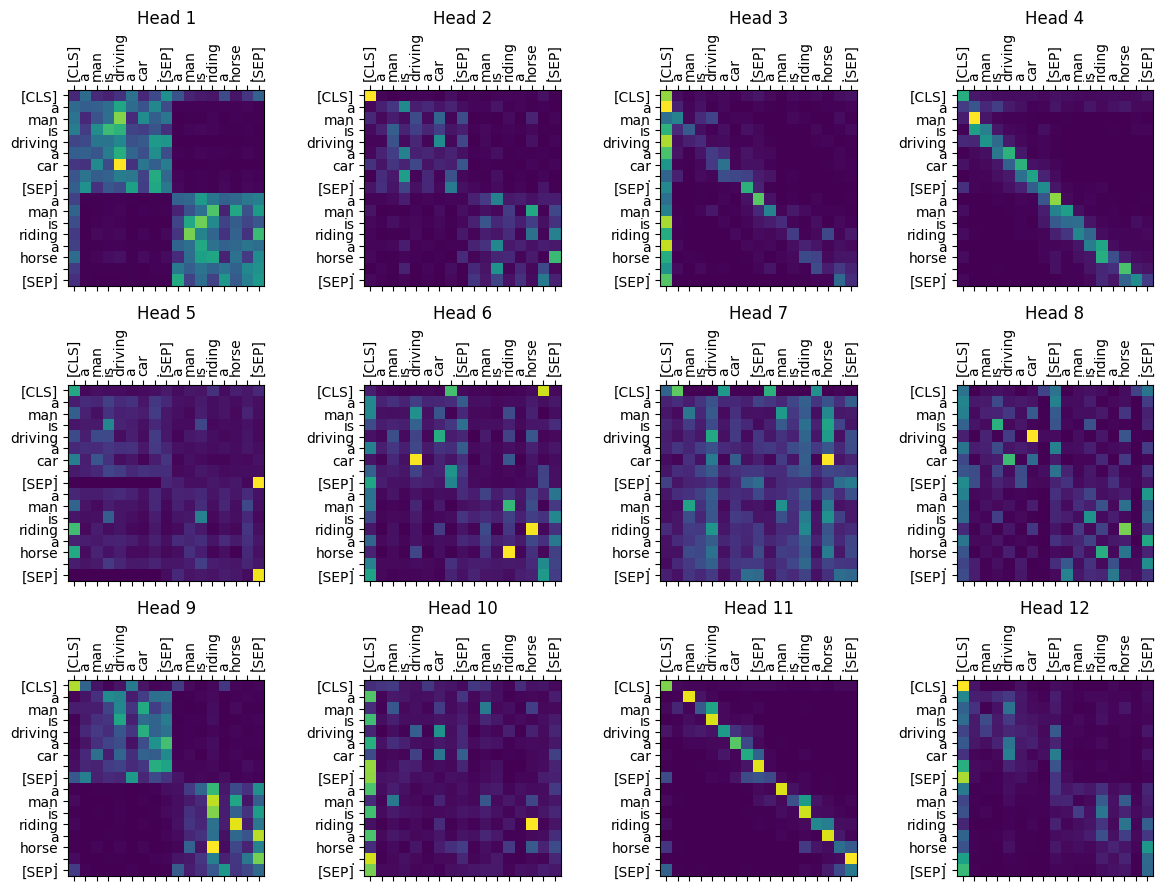

In [ ]:
view_attention(bert, inputs, 0)